### Session Connection

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col

connection_parameters = {
    "account": "<your snowflake account identifier>",
    "user": "<your snowflake username>",
    "password": "<your snowflake password>",
    "role": "<your snowflake role>",
    "warehouse": "<your snowflake warehouse>",  # optional
    "database": "<your snowflake database>",  # optional
    "schema": "<your snowflake schema>" # optional
  }

session = Session.builder.configs(connection_parameters).create()

### Data Aggregation 

* Section covers various aggregation methodology through Snowpark API
* Code snippets encompasses both single, multilevel groupby's and sorting mechanisms 

In [2]:
marketing_final = session.table("MARKETING_FINAL")
marketing_final.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"YEAR_BIRTH"  |"EDUCATION"  |"MARITAL_STATUS"  |"INCOME"  |"KIDHOME"  |"TEENHOME"  |"DT_CUSTOMER"  |"RECENCY"  |"MNTWINES"  |"MNTFRUITS"  |"MNTMEATPRODUCTS"  |"MNTFISHPRODUCTS"  |"MNTSWEETPRODUCTS"  |"MNTGOLDPRODS"  |"NUMDEALSPURCHASES"  |"NUMWEBPURCHASES"  |"NUMCATALOGPURCHASES"  |"NUMSTOREPURCHASES"  |"NUMWEBVISITSMONTH"  |"ACCEPTEDCMP1"  |"ACCEPTEDCMP2"  |"ACCEPTEDCMP3"  |"ACCEPTEDCMP4"  |"ACCEPTEDCMP5"  |"RESPONSE"  |"ID"  |"COMPLAIN"  |"Z_COSTCONTACT"  |"Z_REVENUE"  |
------------------------------------------

In [3]:
# Method 1
marketing_final.group_by("EDUCATION").mean("INCOME").show()

-------------------------------
|"EDUCATION"  |"AVG(INCOME)"  |
-------------------------------
|Graduation   |52720.373656   |
|PhD          |56145.313929   |
|Master       |52917.534247   |
|Basic        |20306.259259   |
|2n Cycle     |47633.190000   |
-------------------------------



In [5]:
### Using Alias For Calculated Column
from snowflake.snowpark.functions import sum, avg, max
marketing_final.group_by("EDUCATION").agg(avg("INCOME").alias("Avg_Income")).show()

------------------------------
|"EDUCATION"  |"AVG_INCOME"  |
------------------------------
|Graduation   |52720.373656  |
|PhD          |56145.313929  |
|Master       |52917.534247  |
|Basic        |20306.259259  |
|2n Cycle     |47633.190000  |
------------------------------



In [6]:
# Method 2
marketing_final.group_by("MARITAL_STATUS").function("sum")("Z_REVENUE").show()

---------------------------------------
|"MARITAL_STATUS"  |"SUM(Z_REVENUE)"  |
---------------------------------------
|Single            |5280              |
|Together          |6380              |
|Married           |9504              |
|Divorced          |2552              |
|Widow             |847               |
|Alone             |33                |
|Absurd            |22                |
|YOLO              |22                |
---------------------------------------



In [7]:
# Method 3
marketing_final.group_by("MARITAL_STATUS").agg(max("INCOME")).show()

------------------------------------
|"MARITAL_STATUS"  |"MAX(INCOME)"  |
------------------------------------
|Single            |113734         |
|Together          |666666         |
|Married           |160803         |
|Divorced          |153924         |
|Widow             |85620          |
|Alone             |61331          |
|Absurd            |79244          |
|YOLO              |48432          |
------------------------------------



In [8]:
# Count of Category
marketing_final.group_by("EDUCATION").agg((col("*"), "count"), max("INCOME")).show()

----------------------------------------------------
|"EDUCATION"  |"COUNT(LITERAL())"  |"MAX(INCOME)"  |
----------------------------------------------------
|Graduation   |1127                |666666         |
|PhD          |486                 |162397         |
|Master       |370                 |157733         |
|Basic        |54                  |34445          |
|2n Cycle     |203                 |96547          |
----------------------------------------------------



In [9]:
# Multi-Level Aggregation 
marketing_final.group_by(["EDUCATION","MARITAL_STATUS"]).agg(
    avg("INCOME").alias("Avg_Income"),
    sum("NUMSTOREPURCHASES").alias("Sum_Purchase")
    ).show()

------------------------------------------------------------------
|"EDUCATION"  |"MARITAL_STATUS"  |"AVG_INCOME"  |"SUM_PURCHASE"  |
------------------------------------------------------------------
|Graduation   |Single            |51322.182927  |1426            |
|Graduation   |Together          |55758.480702  |1686            |
|PhD          |Married           |58138.031579  |1191            |
|Master       |Together          |52109.009804  |600             |
|Graduation   |Divorced          |54526.042017  |697             |
|Graduation   |Married           |50800.258741  |2544            |
|2n Cycle     |Single            |53673.944444  |194             |
|Master       |Married           |53286.028986  |815             |
|Graduation   |Widow             |54976.657143  |206             |
|2n Cycle     |Married           |46201.100000  |440             |
------------------------------------------------------------------



In [10]:
## Multiple metric in Aggregation

marketing_final.group_by("EDUCATION").agg(
    avg("INCOME").alias("Avg_Income"),
    sum("NUMSTOREPURCHASES").alias("Total_Store_Purchase")
    ).show()

-------------------------------------------------------
|"EDUCATION"  |"AVG_INCOME"  |"TOTAL_STORE_PURCHASE"  |
-------------------------------------------------------
|Graduation   |52720.373656  |6570                    |
|PhD          |56145.313929  |2946                    |
|Master       |52917.534247  |2182                    |
|Basic        |20306.259259  |154                     |
|2n Cycle     |47633.190000  |1118                    |
-------------------------------------------------------



In [11]:
# from snowflake.snowpark import GroupingSets
# purchase_history.group_by_grouping_sets(GroupingSets([col("EDUCATION")], [col("MARITAL_STATUS")])).count().show()

##### Sorting

In [12]:
aggregate_result = marketing_final.group_by(["EDUCATION","MARITAL_STATUS"]).agg(
    avg("INCOME").alias("Avg_Income"),
    sum("NUMSTOREPURCHASES").alias("Sum_Purchase")
    )

aggregate_result.sort(col("EDUCATION").asc(), col("Sum_Purchase").asc()).show()

------------------------------------------------------------------
|"EDUCATION"  |"MARITAL_STATUS"  |"AVG_INCOME"  |"SUM_PURCHASE"  |
------------------------------------------------------------------
|2n Cycle     |Widow             |51392.200000  |37              |
|2n Cycle     |Divorced          |49395.130435  |138             |
|2n Cycle     |Single            |53673.944444  |194             |
|2n Cycle     |Together          |44736.410714  |309             |
|2n Cycle     |Married           |46201.100000  |440             |
|Basic        |Widow             |22123.000000  |3               |
|Basic        |Divorced          |9548.000000   |3               |
|Basic        |Together          |21240.071429  |34              |
|Basic        |Single            |18238.666667  |49              |
|Basic        |Married           |21960.500000  |65              |
------------------------------------------------------------------



### Data Analysis

* Sections covers Snowpark API capability to analyse a dataset
* Code snippet involves covering Snowpark API capabilities on - 
    * Data Description
    * Pivoting & Cross tabs
    * Dealing duplicate & missing values
    * Correlation & Covariance
* Also covers converting to pandas dataframe and corresponding capabilities

##### Data Description

In [13]:
marketing_final.describe().show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"YEAR_BIRTH"        |"EDUCATION"  |"MARITAL_STATUS"  |"INCOME"            |"KIDHOME"           |"TEENHOME"          |"RECENCY"           |"MNTWINES"         |"MNTFRUITS"       |"MNTMEATPRODUCTS"   |"MNTFISHPRODUCTS"  |"MNTSWEETPRODUCTS"  |"MNTGOLDPRODS"     |"NUMDEALSPURCHASES"  |"NUMWEBPURCHASES"   |"NUMCATALOGPURCHASES"  |"NUMSTOREPURCHASES"  |"NUMWEBVISITSMONTH"  |"ID"                |"COMPLAIN"           |"Z_COSTCONTACT"  |"Z_REVENUE"  |
----------------------------------------------------------------------------------

##### Distinct Rows

In [15]:
marketing_final.distinct().count()

2240

##### Pivoting

In [131]:
market_subset = marketing_final.select("EDUCATION","MARITAL_STATUS","INCOME")
market_pivot = market_subset.pivot("EDUCATION",["Graduation","PhD","Master","Basic","2n Cycle"]).sum("INCOME")
market_pivot.show()

----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
|Alone             |34176           |35860     |61331       |NULL       |NULL          |
|Absurd            |79244           |NULL      |65487       |NULL       |NULL          |
|YOLO              |NULL            |96864     |NULL        |NULL       |NULL          |
---------------------

##### Crosstab

In [41]:
marketing_final.stat.crosstab(col1="Education",col2="Marital_Status").show()

------------------------------------------------------------------------------------------------------------------------
|"EDUCATION"  |"'Single'"  |"'Together'"  |"'Married'"  |"'Divorced'"  |"'Widow'"  |"'Alone'"  |"'Absurd'"  |"'YOLO'"  |
------------------------------------------------------------------------------------------------------------------------
|Graduation   |252         |286           |433          |119           |35         |1          |1           |0         |
|PhD          |98          |117           |192          |52            |24         |1          |0           |2         |
|Master       |75          |106           |138          |37            |12         |1          |1           |0         |
|Basic        |18          |14            |20           |1             |1          |0          |0           |0         |
|2n Cycle     |37          |57            |81           |23            |5          |0          |0           |0         |
--------------------------------

##### Drop Duplicates

In [78]:
marketing_final.drop_duplicates().count()

2240

In [79]:
marketing_final.select(["Education","Marital_Status"]).drop_duplicates().show()

----------------------------------
|"EDUCATION"  |"MARITAL_STATUS"  |
----------------------------------
|Graduation   |Single            |
|Graduation   |Together          |
|PhD          |Married           |
|Master       |Together          |
|Graduation   |Divorced          |
|Graduation   |Married           |
|Basic        |Married           |
|2n Cycle     |Single            |
|Master       |Married           |
|Master       |Single            |
----------------------------------



##### Dealing with Missing Values

In [93]:
market_pivot.show()

----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
|Alone             |34176           |35860     |61331       |NULL       |NULL          |
|Absurd            |79244           |NULL      |65487       |NULL       |NULL          |
|YOLO              |NULL            |96864     |NULL        |NULL       |NULL          |
---------------------

In [96]:
market_pivot.dropna(how="all").show()

----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
|Alone             |34176           |35860     |61331       |NULL       |NULL          |
|Absurd            |79244           |NULL      |65487       |NULL       |NULL          |
|YOLO              |NULL            |96864     |NULL        |NULL       |NULL          |
---------------------

In [134]:
market_pivot.dropna(thresh=5).show()

----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
----------------------------------------------------------------------------------------



In [101]:
market_pivot.dropna(subset="'Graduation'").show()

----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
|Alone             |34176           |35860     |61331       |NULL       |NULL          |
|Absurd            |79244           |NULL      |65487       |NULL       |NULL          |
----------------------------------------------------------------------------------------



In [102]:
market_pivot.fillna(0).show()

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "MARITAL_STATUS", Type: StringType(), Input Value: 0, Type: <class 'int'>


----------------------------------------------------------------------------------------
|"MARITAL_STATUS"  |"'Graduation'"  |"'PhD'"   |"'Master'"  |"'Basic'"  |"'2n Cycle'"  |
----------------------------------------------------------------------------------------
|Single            |12625257        |5118203   |4014792     |328296     |1932262       |
|Together          |15891167        |6500805   |5315119     |297361     |2505239       |
|Married           |21793311        |11046226  |7353472     |439210     |3696088       |
|Divorced          |6488599         |2761024   |1862282     |9548       |1136088       |
|Widow             |1924183         |1446914   |642417      |22123      |256961        |
|Alone             |34176           |35860     |61331       |0          |0             |
|Absurd            |79244           |0         |65487       |0          |0             |
|YOLO              |0               |96864     |0           |0          |0             |
---------------------

##### Correlation Vs Covariance


In [14]:
marketing_final.stat.corr("INCOME", "NUMSTOREPURCHASES")

0.5293621402734197

In [15]:
marketing_final.stat.cov("INCOME", "NUMSTOREPURCHASES")

43318.897447865325

##### Converting to Pandas Dataframe

In [18]:
pandas_df =  marketing_final.to_pandas()
pandas_df.head()

,YEAR_BIRTH,EDUCATION,MARITAL_STATUS,INCOME,KIDHOME,TEENHOME,DT_CUSTOMER,RECENCY,MNTWINES,MNTFRUITS,...,ACCEPTEDCMP1,ACCEPTEDCMP2,ACCEPTEDCMP3,ACCEPTEDCMP4,ACCEPTEDCMP5,RESPONSE,ID,COMPLAIN,Z_COSTCONTACT,Z_REVENUE
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,0,0,0,0,0,1,5524,0,3,11
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,0,0,0,0,0,0,2174,0,3,11
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,0,0,0,0,0,0,4141,0,3,11
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,0,0,0,0,0,0,6182,0,3,11
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,0,0,0,0,0,0,5324,0,3,11


In [20]:
for batch in marketing_final.to_pandas_batches():
    print(batch.shape)

(1748, 29)
(492, 29)


##### Sampling Data

In [67]:
sample_df = marketing_final.sample(frac=0.50)
sample_df.count()

1128

In [51]:
fractions = {"Graduation": 0.5, "PhD": 0.5,"Master":0.3}
sample_df = marketing_final.stat.sample_by(col="Education",fractions=fractions)
sample_df.count()

955

In [107]:
pandas_df[["INCOME","KIDHOME","RECENCY"]].corr()

,INCOME,KIDHOME,RECENCY
INCOME,1.000000,-0.428669,-0.003970
KIDHOME,-0.428669,1.000000,0.008827
RECENCY,-0.003970,0.008827,1.000000


In [112]:
frequency = pandas_df.EDUCATION.value_counts()
frequency

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: EDUCATION, dtype: int64

<Axes: >

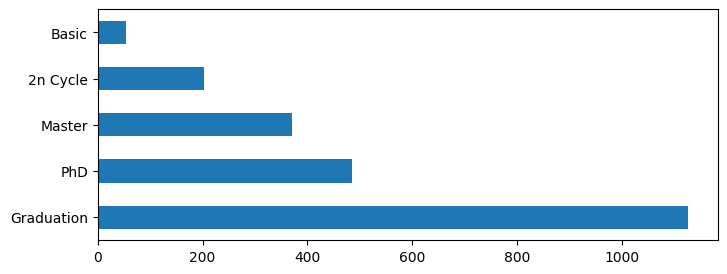

In [138]:
import matplotlib.pyplot as plt
frequency.plot(kind="barh",figsize=(8,3))

<Axes: xlabel='INCOME', ylabel='MNTGOLDPRODS'>

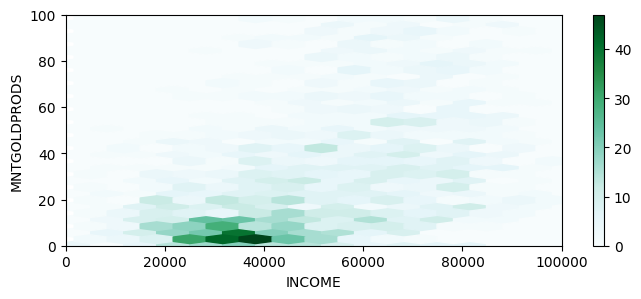

In [139]:
pandas_df.plot(kind="hexbin",x="INCOME",y="MNTGOLDPRODS",xlim=[0,100000],ylim=[0,100],figsize=(8,3))